In [1]:
!pip3 install keras
!pip3 install tensorflow
!pip3 install pydot
!pip3 install graphviz
# Import
import keras,os
from keras.models import Sequential, Model
from keras.callbacks import CSVLogger
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input, concatenate, AveragePooling2D,Dropout
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
# from google.colab import drive
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf

In [14]:
data = pd.read_csv("archive/labels/labels.csv")
data

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [15]:
data.drop(columns='Species')
print(data['Label'].value_counts())

Label
8    9106
0    1125
6    1074
1    1064
4    1062
2    1031
3    1022
7    1016
5    1009
Name: count, dtype: int64


In [96]:
#Split data 80 / 20, due to performance utilizng only 70%
sliced_data = data.groupby('Label').sample(frac=0.7, random_state=2)
sliced_data = sliced_data.drop(sliced_data[sliced_data.Label==8].groupby('Label').sample(frac=0.9, random_state=2).index)
train = sliced_data.groupby('Label').sample(frac=0.8, random_state=2)
test = sliced_data.drop(train.index)

In [97]:
print(train['Label'].value_counts())
print(test['Label'].value_counts())

Label
0    90
6    86
1    85
4    85
2    82
3    82
7    82
5    81
8    73
Name: count, dtype: int64
Label
0    22
1    21
2    21
4    21
6    21
3    20
5    20
7    20
8    18
Name: count, dtype: int64


In [99]:
! mkdir archive/train
! mkdir archive/train/0 archive/train/1 archive/train/2 archive/train/3 archive/train/4 archive/train/5 archive/train/6 archive/train/7 archive/train/8

! mkdir archive/test
! mkdir archive/test/0 archive/test/1 archive/test/2 archive/test/3 archive/test/4 archive/test/5 archive/test/6 archive/test/7 archive/test/8

In [100]:
for index, row in train.iterrows():
  shutil.copyfile("archive/images/" + row["Filename"], "archive/train/" + str(row["Label"]) + "/" + row["Filename"])

In [101]:
for index, row in test.iterrows():
  shutil.copyfile("archive/images/" + row["Filename"], "archive/test/" + str(row["Label"]) + "/" + row["Filename"])

In [2]:
train_data_gr = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.5,
    rotation_range=30
    )
train_data = train_data_gr.flow_from_directory(directory="archive/train", target_size=(224, 224))
train_data_ge = ImageDataGenerator()
test_data = train_data_gr.flow_from_directory(directory="archive/test", target_size=(224, 224))

Found 746 images belonging to 9 classes.
Found 184 images belonging to 9 classes.


In [3]:
#VGG16
vgg16model = Sequential()
vgg16model.add(Conv2D(input_shape=(224, 224, 3), filters=64, kernel_size=(3, 3),padding="same", activation="relu"))
vgg16model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
vgg16model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# vgg16model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# vgg16model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# vgg16model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# vgg16model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# vgg16model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# vgg16model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# vgg16model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# vgg16model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16model.add(Flatten())
vgg16model.add(Dense(units=4096,activation="relu"))
vgg16model.add(Dense(units=4096,activation="relu"))
vgg16model.add(Dense(units=9, activation="softmax"))

In [22]:
vgg16model.compile(optimizer="sgd", loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

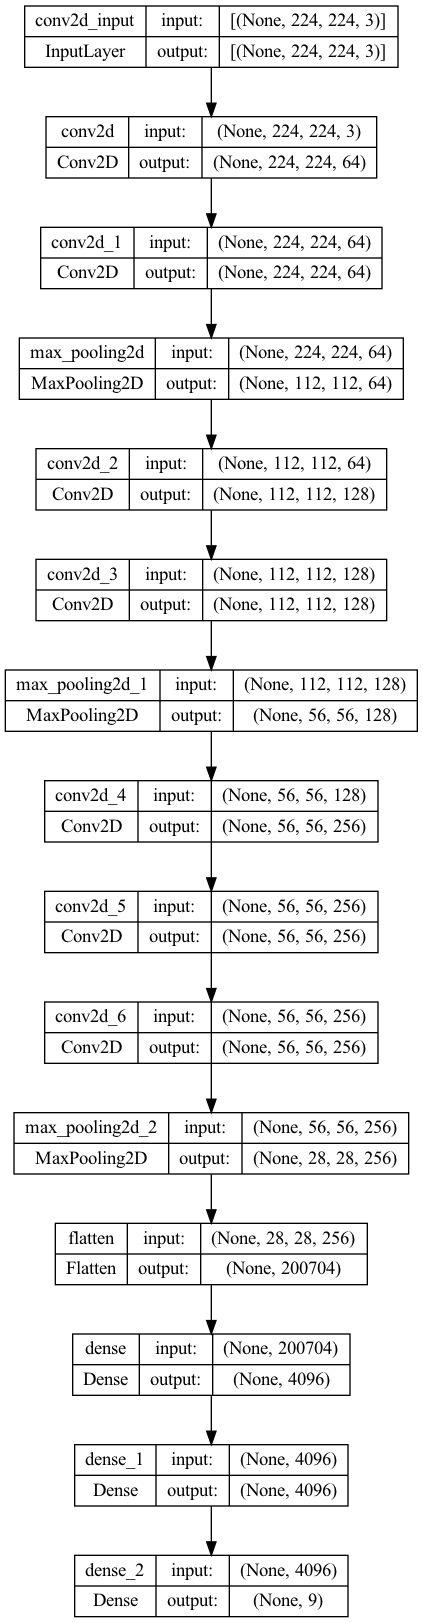

In [23]:
vgg16model.summary()
plot_model(vgg16model, show_shapes=True, to_file='archive/vgg16_module.png')

In [24]:
csv_logger = CSVLogger( 'archive/vgg16-training.log', separator=',', append=False)
vgg16model_fitted = vgg16model.fit(x=train_data, validation_data=test_data, callbacks=[csv_logger], epochs=5, shuffle=True, batch_size=32)

Epoch 1/5
24/24 [==============================] - 320s 13s/step - loss: 2.1961 - accuracy: 0.1206 - val_loss: 2.1960 - val_accuracy: 0.1196
Epoch 2/5
24/24 [==============================] - 202s 9s/step - loss: 2.1961 - accuracy: 0.1206 - val_loss: 2.1960 - val_accuracy: 0.1196
Epoch 3/5
24/24 [==============================] - 213s 9s/step - loss: 2.1961 - accuracy: 0.1206 - val_loss: 2.1960 - val_accuracy: 0.1196
Epoch 4/5
24/24 [==============================] - 200s 8s/step - loss: 2.1961 - accuracy: 0.1206 - val_loss: 2.1960 - val_accuracy: 0.1196
Epoch 5/5
24/24 [==============================] - 199s 8s/step - loss: 2.1961 - accuracy: 0.1206 - val_loss: 2.1960 - val_accuracy: 0.1196


In [7]:
vgg16model.save('archive/vgg16.keras')

In [ ]:
vgg16model = tf.keras.models.load_model('archive/vgg16.keras')

In [8]:
vgg_16model_history = pd.read_csv('archive/vgg16-training.log', sep=',', engine='python')

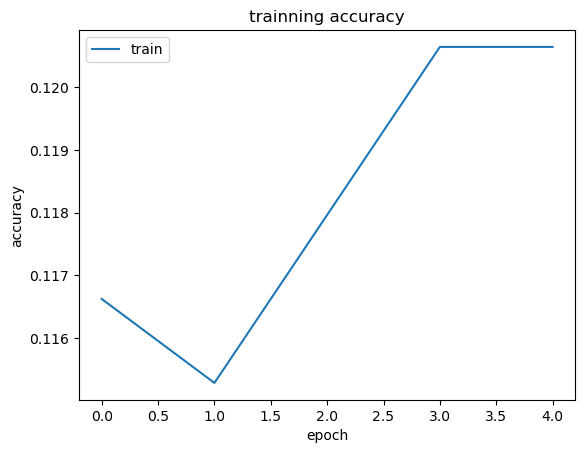

In [9]:
plt.plot(vgg_16model_history['accuracy'])
plt.title('trainning accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

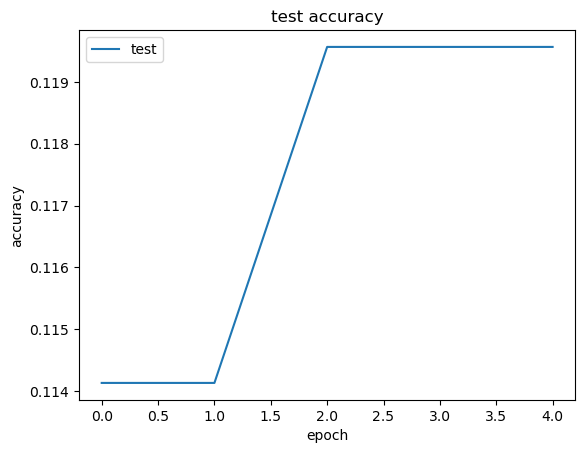

In [10]:
plt.plot(vgg_16model_history['val_accuracy'])
plt.title('test accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

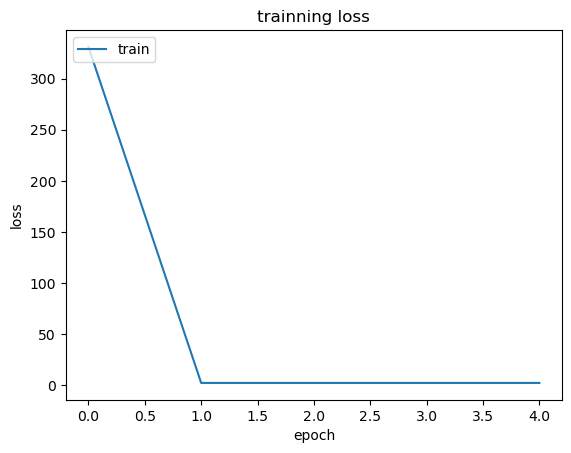

In [11]:
plt.plot(vgg_16model_history['loss'])
plt.title('trainning loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

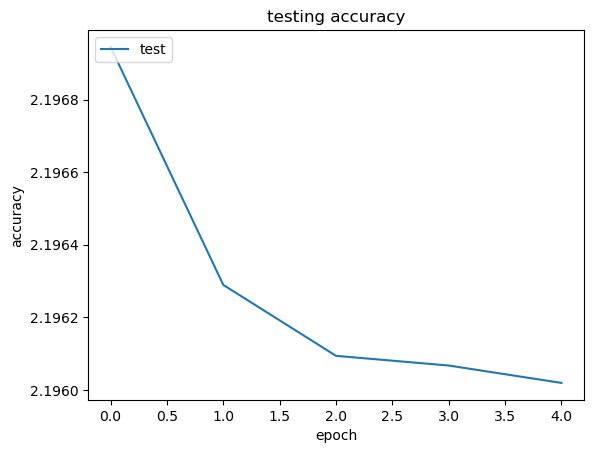

In [12]:
plt.plot(vgg_16model_history['val_loss'])
plt.title('testing loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

In [13]:
# Inception
def inception_block(input, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
 conv1 = Conv2D(f1, (1,1), activation='relu', padding='same')(input)
 max_pool = MaxPool2D((3,3), strides=(1,1), padding='same')(input)

 conv3 = Conv2D(f2_in, (1,1), activation='relu', padding='same')(input)
 conv3 = Conv2D(f2_out, (3,3), activation='relu', padding='same')(conv3)

 conv5 = Conv2D(f3_in, (1,1), activation='relu', padding='same')(input)
 conv5 = Conv2D(f3_out, (5,5), activation='relu', padding='same')(conv5)

 max_pool = Conv2D(f4_out, (1,1), activation='relu', padding='same')(max_pool)

 return concatenate([conv1, conv3, conv5, max_pool], axis=-1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 218, 218, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 108, 108, 64)         0         ['conv2d_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 106, 106, 192)        110784    ['max_pooling2d_3[0][0]'] 

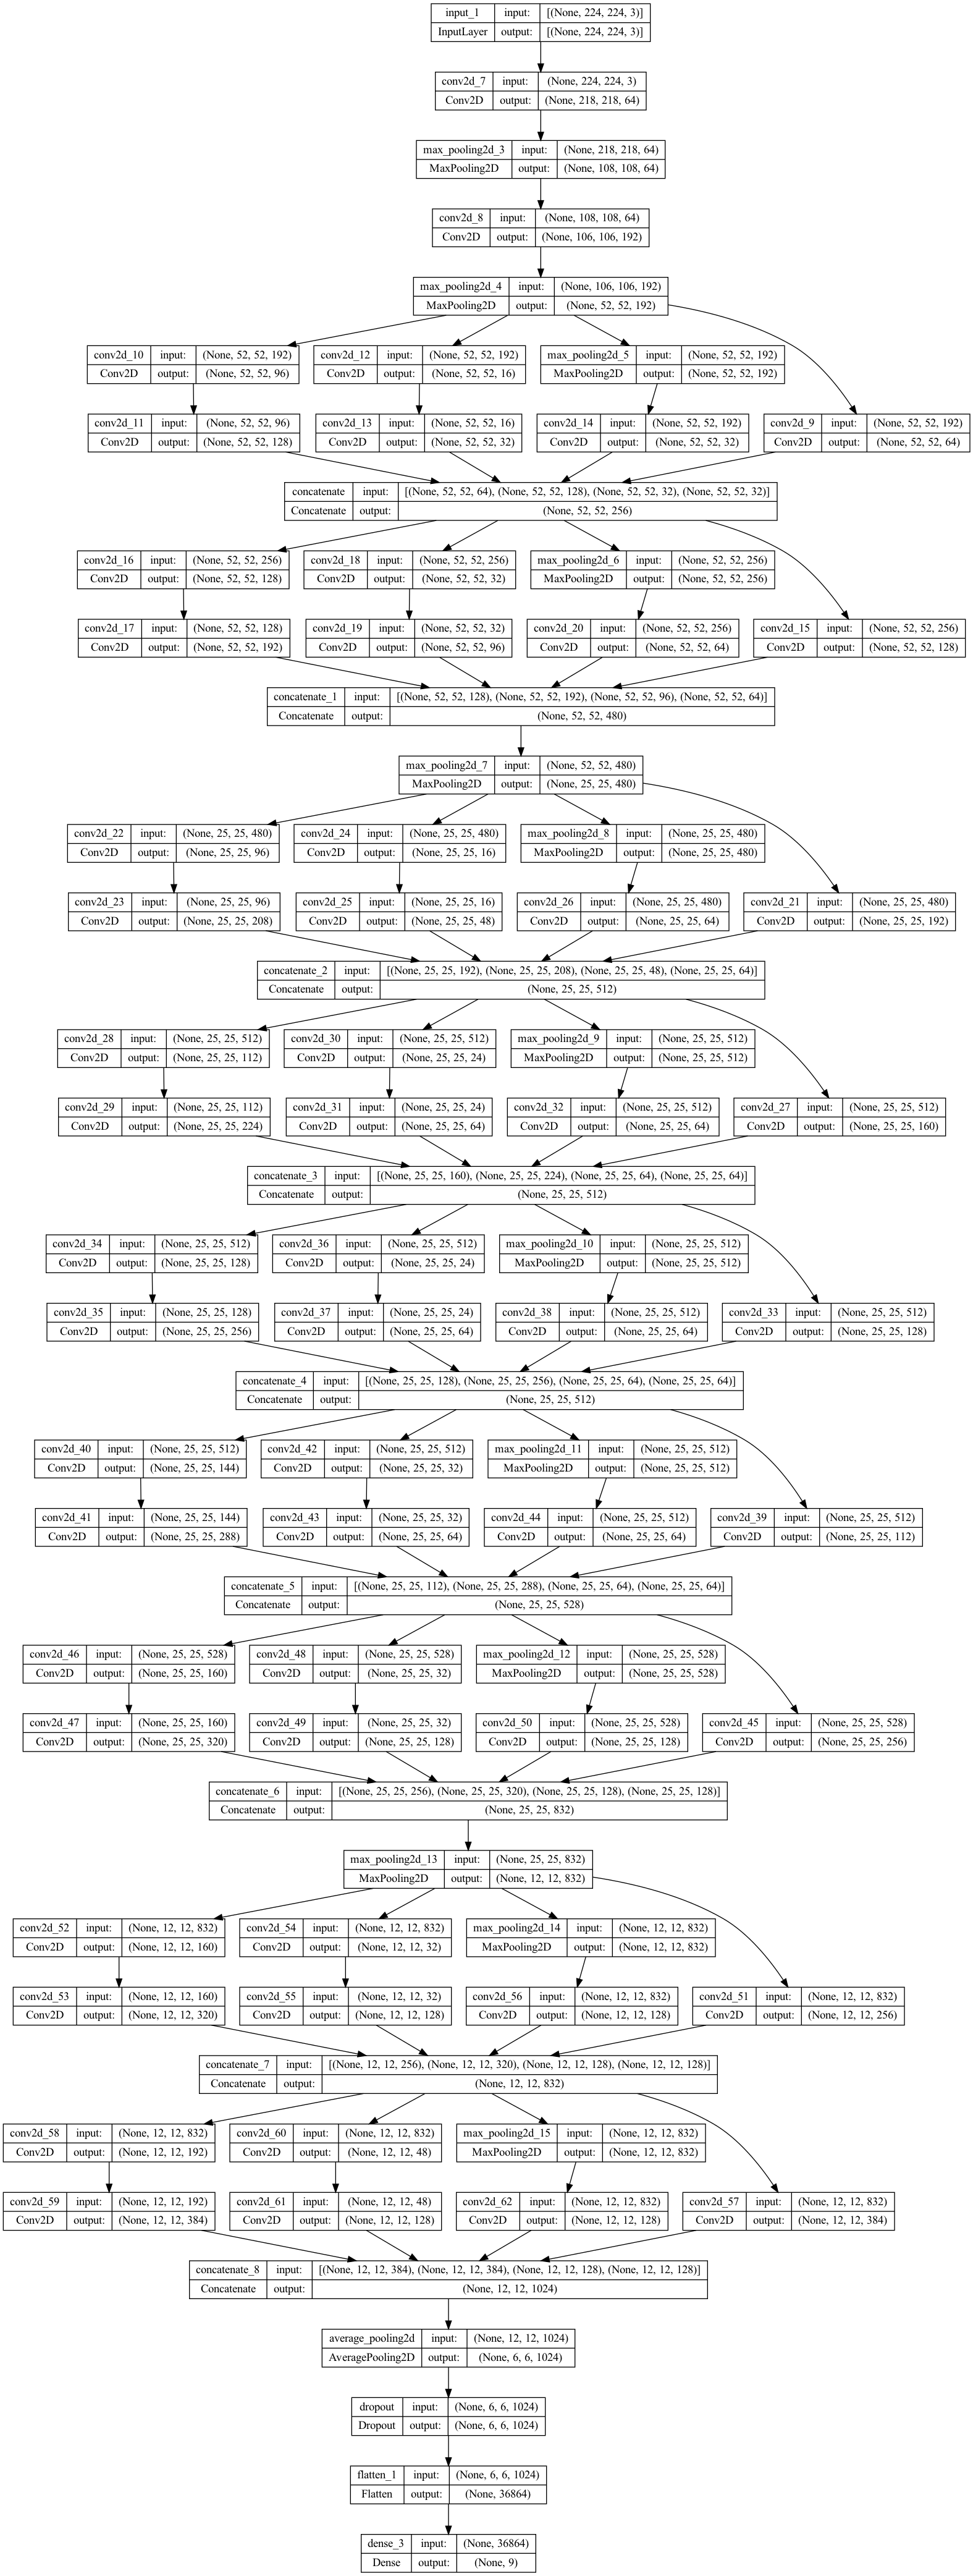

In [14]:
# Inception
# model input
input = Input(shape=(224, 224, 3))
layer = Conv2D(64, (7,7), activation='relu')(input)
layer = MaxPool2D((3,3), strides=(2,2))(layer)
layer = Conv2D(192, (3,3), activation='relu')(layer)
layer = MaxPool2D((3,3), strides=(2,2))(layer)
layer = inception_block(layer, 64, 96, 128, 16, 32, 32)
layer = inception_block(layer, 128, 128, 192, 32, 96, 64)
layer = MaxPool2D((3,3), strides=(2,2))(layer)

layer = inception_block(layer, 192, 96, 208, 16, 48, 64)
layer = inception_block(layer, 160, 112, 224, 24, 64, 64)
layer = inception_block(layer, 128, 128, 256, 24, 64, 64)
layer = inception_block(layer, 112, 144, 288, 32, 64, 64)
layer = inception_block(layer, 256, 160, 320, 32, 128, 128)

layer = MaxPool2D((3,3), strides=(2,2))(layer)
layer = inception_block(layer, 256, 160, 320, 32, 128, 128)
layer = inception_block(layer, 384, 192, 384, 48, 128, 128)
layer = AveragePooling2D((7, 7), strides=(1, 1))(layer)
layer = Dropout(0.4)(layer)
layer = Flatten()(layer)
layer = Dense(9, activation="softmax")(layer)

inception = Model(inputs=input, outputs=layer)
# summarize model
inception.summary()
# plot model architecture
plot_model(inception, show_shapes=True, to_file='archive/inception_module.png')


In [15]:
inception.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
csv_logger = CSVLogger( 'archive/inception-training.log', separator=',', append=False)
inceptionmodel_fitted = inception.fit(x=train_data, validation_data=test_data, callbacks=[csv_logger], epochs=5, shuffle=True, batch_size=32)

Epoch 1/5
24/24 [==============================] - 94s 4s/step - loss: 3.1302 - accuracy: 0.1220 - val_loss: 2.2008 - val_accuracy: 0.1196
Epoch 2/5
24/24 [==============================] - 91s 4s/step - loss: 2.2011 - accuracy: 0.1206 - val_loss: 2.1941 - val_accuracy: 0.1196
Epoch 3/5
24/24 [==============================] - 91s 4s/step - loss: 2.1962 - accuracy: 0.1220 - val_loss: 2.1965 - val_accuracy: 0.2011
Epoch 4/5
24/24 [==============================] - 91s 4s/step - loss: 2.1984 - accuracy: 0.1046 - val_loss: 2.1967 - val_accuracy: 0.1141
Epoch 5/5
24/24 [==============================] - 90s 4s/step - loss: 2.1973 - accuracy: 0.1247 - val_loss: 2.1933 - val_accuracy: 0.1141


In [16]:
inception.save('archive/inception.keras')

In [ ]:
inception = tf.keras.models.load_model('archive/inception.keras')

In [17]:
inceptionmodel_history = pd.read_csv('archive/inception-training.log', sep=',', engine='python')

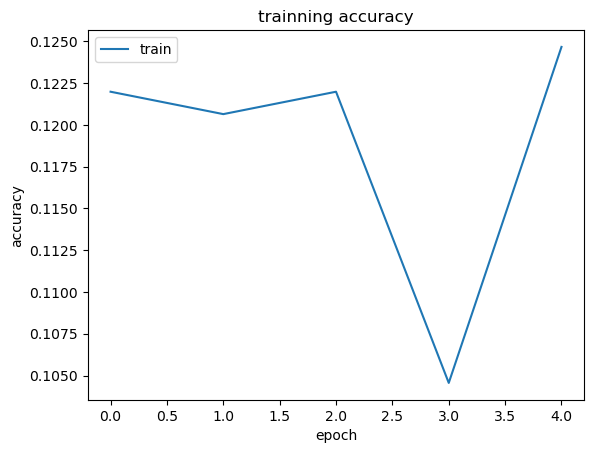

In [18]:
plt.plot(inceptionmodel_history['accuracy'])
plt.title('trainning accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

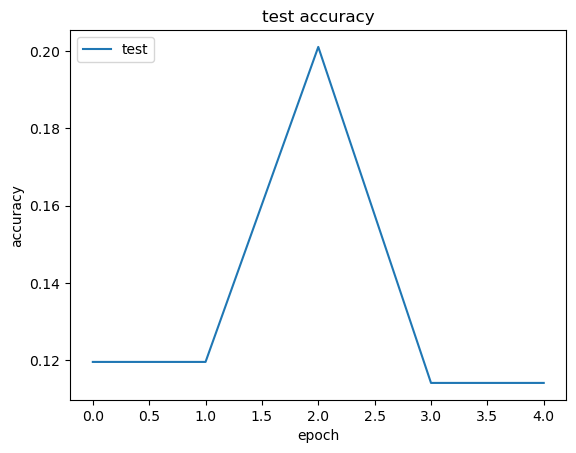

In [19]:
plt.plot(inceptionmodel_history['val_accuracy'])
plt.title('test accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

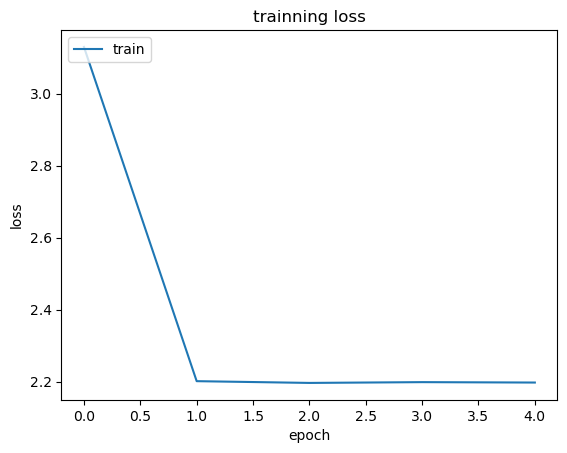

In [20]:
plt.plot(inceptionmodel_history['loss'])
plt.title('trainning loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

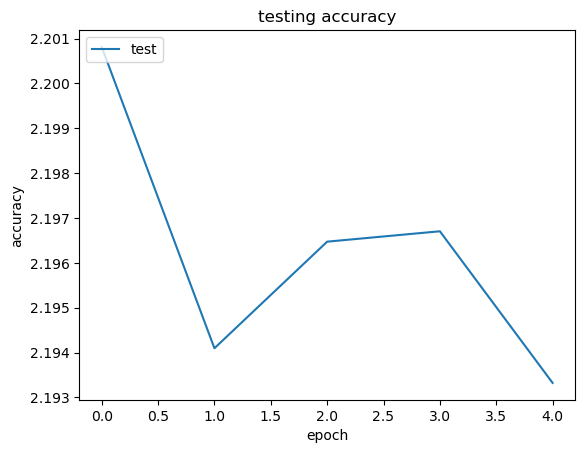

In [21]:
plt.plot(inceptionmodel_history['val_loss'])
plt.title('testing accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()